
# DISPARIDADE MÁXIMA DE PIXELS DE IMAGENS UTILIZANDO REDES NEURAIS



## 1. Objetivos

O objetivo deste trabalho é desenvolver um modelo para prever a máxima disparidade para cada coluna das imagens de um sistema de visão estéreo, utilizando redes neurais com segmentação semântica do tipo codificador-decodificador. Para o modelo foi utilizado o conjunto de dados de um projeto arquitetônico com imagens sintéticas de um centro urbano. 




### Importação das principais bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import os

print(tf.__version__)

2.8.0


## 2. Conjunto de dados

O conjunto de dados utilizado é o do projeto arquitetônico Downtown Development.

Esse conjunto de dados é composto por quase 5.136 pares de imagens com dimensão 640x360 pixels.

O diretório "images" é subdividido nos diretórios "left" e "right" onde ficam as imagens das câmeras esquerda e direita respectivamente. O diretório "depth" é subdividido nso diretórios "left" e "right" onde ficam os mapas de diretórios referentes às imagens da esquerda e da direita respectivamente. Nesse trabalho foi utilizado apenas o mapa de disparidade referente è câmera da esquerda.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Pós/TCC

/content/gdrive/MyDrive/Pós/TCC


In [ ]:
# Define diretório onde se encontram as imagens
left_image_path = 'images/left/'
right_image_path = 'images/right/'
disp_image_path = 'images/depth/left/'

# Escolhe tipos de arquivos desejados
glob_left_imgs = os.path.join(left_image_path, '*.jpg')
glob_right_imgs = os.path.join(right_image_path, '*.jpg')
glob_disp_imgs = os.path.join(disp_image_path, '*.jpg')

# Cria lista dos nomes dos arquivos
left_img_paths = glob(glob_left_imgs)
right_img_paths = glob(glob_right_imgs)
disp_img_paths = glob(glob_disp_imgs)

# Ordena lista dos arquivos
left_img_paths.sort()
right_img_paths.sort()
disp_img_paths.sort()

# Apresenta numero de imagens
print('Número de imagens da esquerda:', len(left_img_paths))
print('Número de imagens da direita:', len(right_img_paths))
print('Número de imagens de disparidade:', len(disp_img_paths))
print(' ')

# Imprime nomes e paths dos 5 primeiros arquivos das listas
print('Nomes dos 5 primeiros arquivos das listas:')
print(' ')
print(left_img_paths[:5])
print(' ')
print(right_img_paths[:5])
print(' ')
print(disp_img_paths[:5])

Número de imagens da esquerda: 5136
Número de imagens da direita: 5136
Número de imagens de disparidade: 5136
 
Nomes dos 5 primeiros arquivos das listas:
 
['images/left/L_00000.jpg', 'images/left/L_00001.jpg', 'images/left/L_00002.jpg', 'images/left/L_00003.jpg', 'images/left/L_00004.jpg']
 
['images/right/D_00000.jpg', 'images/right/D_00001.jpg', 'images/right/D_00002.jpg', 'images/right/D_00003.jpg', 'images/right/D_00004.jpg']
 
['images/depth/left/L_Depth_00000.jpg', 'images/depth/left/L_Depth_00001.jpg', 'images/depth/left/L_Depth_00002.jpg', 'images/depth/left/L_Depth_00003.jpg', 'images/depth/left/L_Depth_00004.jpg']


Para entender esse conjunto de dados vamos visualizar alguns pares de imagens e o mapa de disparidade.

Dimensões das imagens: (360, 640, 3)
Dimensões da imagem de disparidade: (360, 640, 3)
Valor máximo dos pixels das imagens: 255.0
Valor máximo da disparidade: 255.0


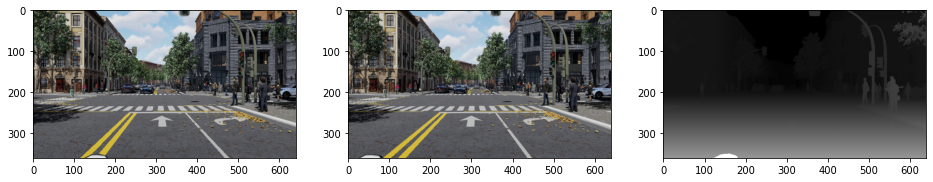

In [ ]:
# Importa função para ler imagem
from keras.preprocessing.image import load_img, img_to_array

# Seleção da imagem
index = 0

# Carrega algumas imagens
img_left = load_img(left_img_paths[index])
img_right = load_img(right_img_paths[index])
img_disp = load_img(disp_img_paths[index])

# convert to numpy array
img_left = img_to_array(img_left)
img_right = img_to_array(img_right)
img_disp = img_to_array(img_disp)

# Mostra imagens 
f, pos = plt.subplots(1, 3, figsize=(16, 16))
pos[0].imshow(img_left/255)
pos[1].imshow(img_right/255)
pos[2].imshow(img_disp/255)

# Mostra dimensões 
print('Dimensões das imagens:', img_left.shape)
print('Dimensões da imagem de disparidade:', img_disp.shape)
print('Valor máximo dos pixels das imagens:', np.max(img_left))
print('Valor máximo da disparidade:', np.max(img_disp))

### 2.2 Divisão dos dados em conjuntos de treinamento e validação

Como essa imagens foram obtidas em sequência, como se fosse um vídeo, e não vamos usar a informação temporal então temos que embaralhar os exemplos, antes de usá-los e antes de dividir os dados nos conjunto de treinamento e validação.

In [ ]:
# Importa função para embaralhar os dados
from sklearn.utils import shuffle

left_img_paths, right_img_paths, disp_img_paths = shuffle(left_img_paths, right_img_paths, disp_img_paths)

# Imprime nomes e paths dos 5 primeiros arquivos das listas
print('Nomes dos 5 primeiros arquivos das listas:')
print(' ')
print(left_img_paths[:5])
print(' ')
print(right_img_paths[:5])
print(' ')
print(disp_img_paths[:5])

Nomes dos 5 primeiros arquivos das listas:
 
['images/left/L_03882.jpg', 'images/left/L_02528.jpg', 'images/left/L_01887.jpg', 'images/left/L_04276.jpg', 'images/left/L_00493.jpg']
 
['images/right/D_03882.jpg', 'images/right/D_02528.jpg', 'images/right/D_01887.jpg', 'images/right/D_04276.jpg', 'images/right/D_00493.jpg']
 
['images/depth/left/L_Depth_03882.jpg', 'images/depth/left/L_Depth_02528.jpg', 'images/depth/left/L_Depth_01887.jpg', 'images/depth/left/L_Depth_04276.jpg', 'images/depth/left/L_Depth_00493.jpg']


In [ ]:
# Conjunto de dados de treinamento
train_left_img_paths = left_img_paths[:4109]
train_right_img_paths = right_img_paths[:4109]
train_disp_img_paths = disp_img_paths[:4109]

# Conjunto de dados de validação
val_left_img_paths = left_img_paths[4109:]
val_right_img_paths = right_img_paths[4109:]
val_disp_img_paths = disp_img_paths[4109:]

# Numero de exemplos
print(len(train_left_img_paths), len(train_right_img_paths), len(train_disp_img_paths))
print(len(val_left_img_paths), len(val_right_img_paths), len(val_disp_img_paths))

4109 4109 4109
1027 1027 1027


## 3. Gerador de dados

A dimensão das imagens de entrada e o mapa de disparidade são 480x640x3 e o conjunto de dados de treinamento possui 1.500 exemplos e o de validação 300 exemplos. Assim, não é possível carregar todas essas em tensores, portanto, temos que usar geradores de dados para carregar os lote de exemplos de treinamento e de validação um de cada vez.

Na célula abaixo é criado um gerador que carrega as imagens dos diretórios onde se encontram e realiza as seguintes operações para criar os exemplos de treinamento e de validação:

1. Carrega as imagens da esquerda, da direita e o mapa de disparidade
2. Transforma as imagens em tensores
3. Redimensiona as imagens e o mapa de disparidade (essa imagens são muito grandes para o hardware disponível)
4. Normaliza as imagem de entrada para que os valores dos seus pixels sejam números reais entre 0 e 1

In [ ]:
#from skimage.transform import 
from keras.preprocessing.image import load_img, img_to_array

# Cria gerador para ser usado com o Keras
def batch_generator(left_img_paths, right_img_paths, disp_img_paths, img_size, m_exemplos, batchsize):
    # Inicializa loop infinito que termina no final do treinamento
    while True:
        
        # Loop para selecionar imagens de cada lote
        for start in range(0, m_exemplos, batchsize):
           
            # Inicializa lista de imagens com máscara e sem máscara
            batch_left_img, batch_right_img, batch_disp_img = [], [], []
        
            end = min(start + batchsize, m_exemplos)
            for i in range(start, end):
                # Carrega images e o mapa de disparidade
                left_imagem = load_img(left_img_paths[i])
                right_imagem = load_img(right_img_paths[i])
                disp_imagem = load_img(disp_img_paths[i], color_mode='grayscale')
                
                # Converte para tensor 
                left_imagem = img_to_array(left_imagem)
                right_imagem = img_to_array(right_imagem)
                disp_imagem = img_to_array(disp_imagem)

                # Elimina 4o canal
                left_imagem = left_imagem[:,:,:3]
                right_imagem = right_imagem[:,:,:3]
                
                # Redimensiona imagens e normaliza
                left_imagem = tf.image.resize(left_imagem, img_size)/255.
                right_imagem = tf.image.resize(right_imagem, img_size)/255.
                disp_imagem = tf.image.resize(disp_imagem, img_size)
                
                # Obtém a metade da dimensão da altura da imagem
                linha = round(img_size[0]/2)

                # Obtém os valores máximos de cada coluna até a metade da imagem
                disp_imagem = np.max(disp_imagem[:linha,:,0], axis=0)
                
                # Adiciona imagem original e segmentada aos lotes
                batch_left_img.append(left_imagem)
                batch_right_img.append(right_imagem)
                batch_disp_img.append(disp_imagem)
            
            yield [np.stack(batch_left_img, axis=0), np.stack(batch_right_img, axis=0)], np.stack(batch_disp_img, axis=0)

As duas células abaixo testam o gerador de dados nos exemplos de treinamento e de validação.

Dimensão dos tensores de imagens = (4, 120, 160, 3) (4, 120, 160, 3) (4, 160)
Nomes dos arquivos:
images/left/L_03882.jpg
images/right/D_03882.jpg


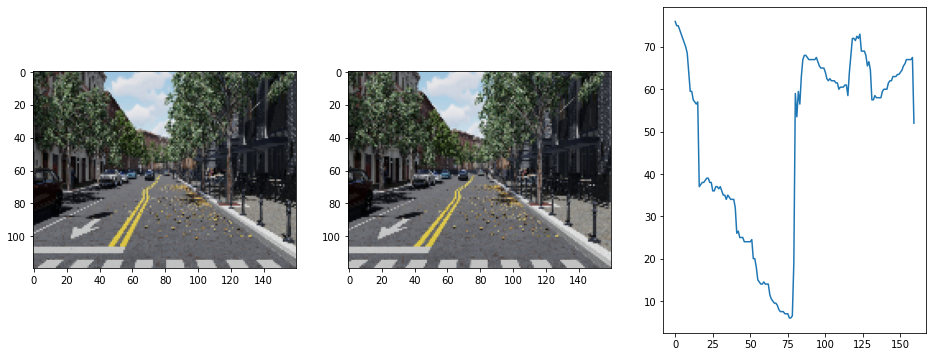

In [ ]:
# Número de exemplos
m_train = len(train_left_img_paths)
m_val = len(val_left_img_paths)

# Dimensão desejada para as imagens
img_size = (120, 160)

# Instancia o gerador de dados de treinamento
train_datagen = batch_generator(train_left_img_paths, train_right_img_paths, train_disp_img_paths, img_size, m_train, batchsize=4)

# Usa o gerador uma vez
[left_img_batch, right_img_batch], disp_img_batch = next(train_datagen)

# Apresenta dimensão dos tensores de entrada de saída
print('Dimensão dos tensores de imagens =', left_img_batch.shape, right_img_batch.shape, disp_img_batch.shape)

# Mostra uma imagem dos lotes gerados
index = 0
print('Nomes dos arquivos:')
print(train_left_img_paths[index])
print(train_right_img_paths[index])
f, pos = plt.subplots(1, 3, figsize=(16, 6))
pos[0].imshow(left_img_batch[index])
pos[1].imshow(right_img_batch[index])
pos[2].plot(disp_img_batch[index])
plt.show()

Dimensão dos tensores de imagens = (4, 120, 160, 3) (4, 120, 160, 3) (4, 160)
Nomes das imagens:
images/left/L_01228.jpg
images/right/D_01228.jpg


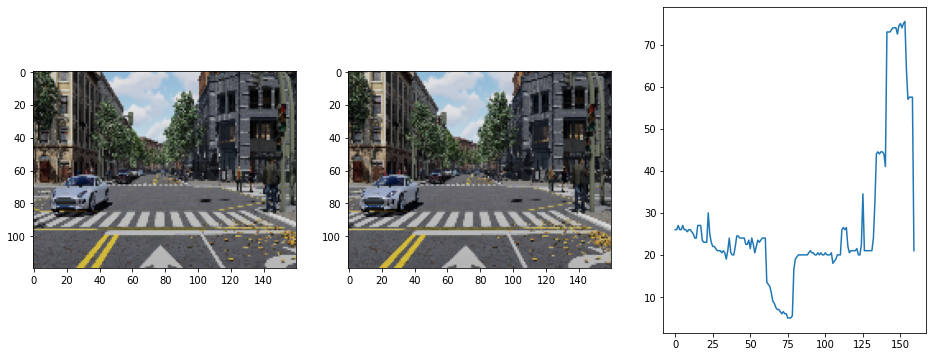

In [ ]:
# Instancia o gerador de dados de tvaçidação
val_datagen = batch_generator(val_left_img_paths, val_right_img_paths, val_disp_img_paths, img_size, m_val, batchsize=4)

# Usa o gerador uma veze
[left_img_batch, right_img_batch], disp_img_batch = next(val_datagen)

# Apresenta dimensão dos tensores de entrada de saída
print('Dimensão dos tensores de imagens =', left_img_batch.shape, right_img_batch.shape, disp_img_batch.shape)

# Mostra uma imagem dos lotes gerados
index = 0
print('Nomes das imagens:')
print(val_left_img_paths[index])
print(val_right_img_paths[index])
f, pos = plt.subplots(1, 3, figsize=(16, 6))
pos[0].imshow(left_img_batch[index])
pos[1].imshow(right_img_batch[index])
pos[2].plot(disp_img_batch[index])
plt.show()

In [ ]:
# Define tamanho do lote
batch_size = 45

# Calcula números de lotes por época
train_steps = len(train_left_img_paths) // batch_size
val_steps = len(val_left_img_paths) // batch_size

print('Passos de treinamento:', train_steps)
print('Passos de validação:', val_steps)

Passos de treinamento: 91
Passos de validação: 22


## 4. Configuração e treinamento da rede


### 4.1 Configuração

Para resolver esse problema de visão estéreo vamos usar uma rede do tipo codificadora-decodificadora.

Estrutura da rede:

1. Dados de entrada: imagens da esquerda e da direita do sistema de visão estéreo


2. Saída: máxima disparidade


3. Parte codificadora consiste em uma rede siamesa para extração de características das imagens esquerda e direita


4. Rede siamesa: 
    - 4 camadas convolucionais
    - 2 duas de maxpooling
    - dropout é usada nas 3 primeiras camadas
    - todas as camadas possuem batch normalization
    
    
5. Características das imagens esquerda e direita são concatenadas pelo segundo eixo


6. Parte decodificadora:
    - 2 camadas de convolução transposta
    - 3 camadas de convolução normal
    - A primeira camada de convolução normal usa batch normalization e dropout 
    

7. Todas as camadas possuem função de ativação relu e padding=same


In [ ]:
from tensorflow.python.keras.layers.pooling import GlobalAveragePooling2D
# Importa funções necessárias
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Conv2DTranspose, Dense, Flatten
from tensorflow.keras.layers import concatenate, BatchNormalization

# Define dimensão das imagens de entrada
input_shape = (120, 160, 3)

#### Rede de extração de características ####
rna_carac = Sequential()

rna_carac.add(Conv2D(32, (3,3), padding='same', activation='linear', use_bias=False))
rna_carac.add(BatchNormalization())
rna_carac.add(Activation('relu'))
rna_carac.add(Dropout(0.2))
rna_carac.add(MaxPooling2D(2,2))

rna_carac.add(Conv2D(64, (3,3), padding='same', activation='linear', use_bias=False))
rna_carac.add(BatchNormalization())
rna_carac.add(Activation('relu'))
rna_carac.add(Dropout(0.2))
rna_carac.add(MaxPooling2D(2, 2))

rna_carac.add(Conv2D(128, (3,3), padding='same', activation='linear', use_bias=False))
rna_carac.add(BatchNormalization())
rna_carac.add(Activation('relu'))
rna_carac.add(Dropout(0.2))

rna_carac.add(Conv2D(256, (3,3), padding='same', activation='linear', use_bias=False))
rna_carac.add(BatchNormalization())
rna_carac.add(Activation('relu'))

#### Rede de calculo da profundidade ####
# Define entradas
input_left = tf.keras.layers.Input(shape=input_shape)
input_right = tf.keras.layers.Input(shape=input_shape)

# Processa imagens para gerar as características
carac_left = rna_carac(input_left)
carac_right = rna_carac(input_right)

# Une os vetores de características
x1 = concatenate([carac_left, carac_right], axis=3)
                                   
# Aplica convolução
x2 = Conv2DTranspose(256, (3,3), padding='same', activation='relu', strides=(2,2))(x1)
x3 = Conv2DTranspose(128, (3,3), padding='same', activation='relu', strides=(1,2))(x2)
x4 = Conv2D(64, (3,3), padding='same', activation='linear', use_bias=False)(x3)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Dropout(0.2)(x4)
x5 = Conv2D(1, (3,3), padding='same', activation='linear', use_bias=False)(x3)
x5 = Flatten()(x5)
x6 = Dense(160, activation='relu')(x5)

# cria rede siamesa
rna_stereo = Model([input_left, input_right], x6)

# Apresenta sumario
rna_stereo.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 120, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_14 (InputLayer)          [(None, 120, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_6 (Sequential)      (None, 30, 40, 256)  389856      ['input_13[0][0]',               
                                                                  'input_14[0][0]']         

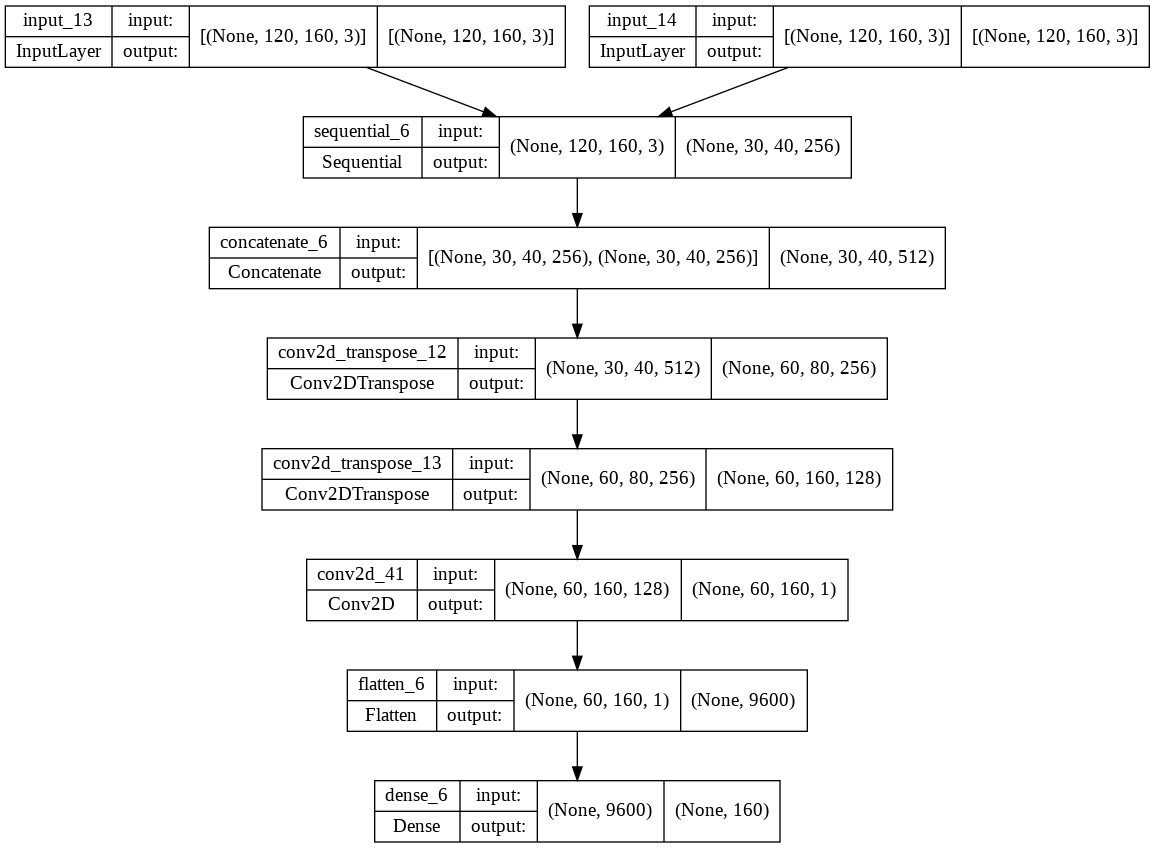

In [ ]:
# Gera um esquema gráfico da rede
from tensorflow.keras.utils import plot_model
plot_model(rna_stereo, show_shapes=True)

### 4.2 Compilação e treinamento

A compilação da rede é feita usando os seguintes parâmetros:
    
1. Método de otimização: Adam com taxa de aprendizado de 0.001
2. Função de custo: erro quadrático médio (mse)
3. Métrica: erro absoluto médio (mae)

In [ ]:
# Importa classe dos otimizadores
from tensorflow.keras import optimizers

# Configura otimizador
adam = optimizers.Adam(learning_rate=0.001)
rna_stereo.compile(optimizer=adam, loss='mse', metrics=['mae'])

O treinamento da rede é realizado usando 100 épocas. 

Como o treinamento é demorado, então, é conveniente utilizar um `callback` para salvar os parâmetros da rede durante o processo de treinamento.

In [ ]:
# Importa callback para salvar modelo durante treinamento
from tensorflow.keras.callbacks import ModelCheckpoint

# Define o callback para salvar os parâmetros
checkpointer = ModelCheckpoint('rna_stereo.h5', verbose=1, save_best_only=True)

# Treinamento da rede
results = rna_stereo.fit(
          batch_generator(train_left_img_paths, train_right_img_paths, train_disp_img_paths, img_size, m_train, batchsize=batch_size),
          steps_per_epoch=train_steps, 
          epochs=100,
          validation_data=batch_generator(val_left_img_paths, val_right_img_paths, val_disp_img_paths, img_size, m_val, batchsize=batch_size),
          validation_steps=val_steps,
          callbacks=[checkpointer],
          verbose=1)     

Epoch 1/100
91/91 [==============================] - ETA: 0s - loss: 281.6434 - mae: 9.9222
Epoch 1: val_loss improved from inf to 1148.46387, saving model to rna_stereo.h5
91/91 [==============================] - 141s 2s/step - loss: 281.6434 - mae: 9.9222 - val_loss: 1148.4639 - val_mae: 26.6658
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 61.0944 - mae: 4.7808
Epoch 2: val_loss improved from 1148.46387 to 945.19312, saving model to rna_stereo.h5
91/91 [==============================] - 139s 2s/step - loss: 61.0944 - mae: 4.7808 - val_loss: 945.1931 - val_mae: 22.9777
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss: 35.2631 - mae: 3.9822
Epoch 3: val_loss improved from 945.19312 to 797.34656, saving model to rna_stereo.h5
91/91 [==============================] - 139s 2s/step - loss: 35.2631 - mae: 3.9822 - val_loss: 797.3466 - val_mae: 20.3214
Epoch 4/100
91/91 [==============================] - ETA: 0s - loss: 23.6634 - mae: 3.4557
Epoch 4

### 4.3 Salva a rede treinada

Após o término do processo de treinamento a rede e os seus parâmetros são salvos.

In [ ]:
rna_stereo.save('tmp/rna_stereo.h5')

Com a rede salva é possível carregá-la mesmo após fechar esse notebook.

In [ ]:
# Importa função para carregar rede
from keras.models import load_model

# carrega rede e apresenta seu sumário
rna_stereo = load_model('tmp/rna_stereo.h5')
rna_stereo.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 120, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_14 (InputLayer)          [(None, 120, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_6 (Sequential)      (None, 30, 40, 256)  389856      ['input_13[0][0]',               
                                                                  'input_14[0][0]']         

### 4.4 Resultados

As células abaixo apresentam os gráficos do processo de treinamento e a avaliação da rede pelo cálculo da função de custo e métrica para os dados de treinamento e validação.

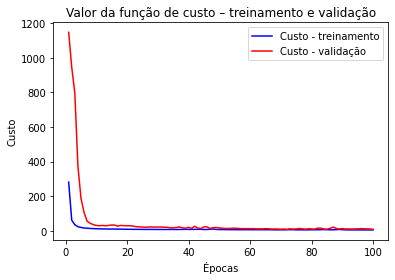

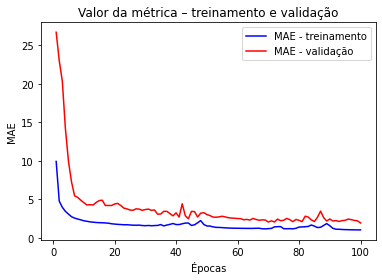

In [ ]:
# Obtém dicionário com os resultados do treinamento
results_dict = results.history

# Salva custos, métricas e epocas em vetores 
custo = results_dict['loss']
mae = results_dict['mae']
val_custo = results_dict['val_loss']
val_mae = results_dict['val_mae']

# Cria vetor de épocas
epocas = range(1, len(custo) + 1)

# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento')
plt.plot(epocas, val_custo, 'r', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocas, mae, 'b', label='MAE - treinamento')
plt.plot(epocas, val_mae, 'r', label='MAE - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
custo_metrica_train = rna_stereo.evaluate(batch_generator(train_left_img_paths, train_right_img_paths, train_disp_img_paths, img_size, m_train, batchsize=batch_size), steps=train_steps)
custo_metrica_val = rna_stereo.evaluate(batch_generator(val_left_img_paths, val_right_img_paths, val_disp_img_paths, img_size, m_val, batchsize=batch_size), steps=val_steps)

22/22 [==============================] - 975s 46s/step - loss: 8.3950 - mae: 1.9272


## 5. Previsões da rede

Vamos verificar se a rede desenvolvida é eficaz em realizar segmentação de imagens. Para isso vamos calcular a sua previsão para alguns exemplos  do conjunto de validação e verificar a qualidade o mapa de disparidade e compará-lo com o mapa de dispatidade real.

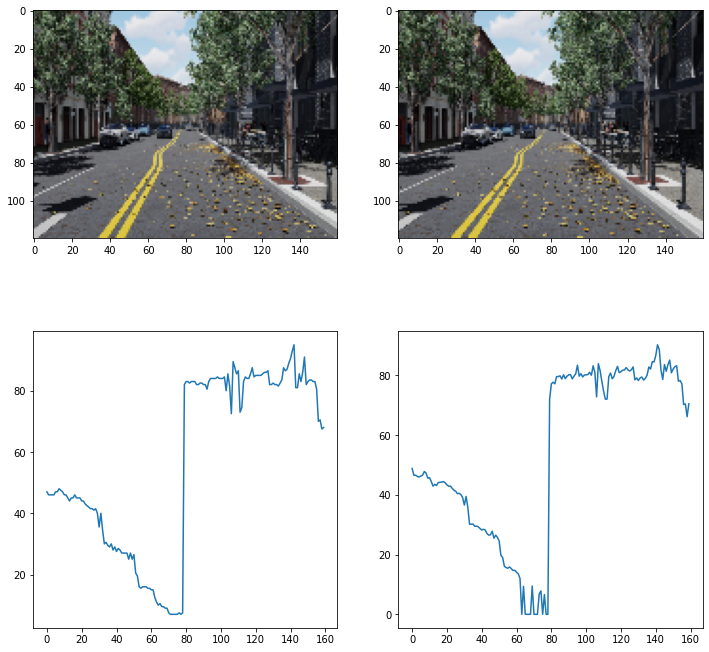

In [ ]:
# Instancia o gerador de dados de validação
datagen = batch_generator(val_left_img_paths, val_right_img_paths, val_disp_img_paths, img_size, m_val, batchsize=150)

# Gera lote de exemplos de valiação
[left_img_batch, right_img_batch], disp_img_batch = next(datagen) 

# Calcula previsão da rede para o lote de validação gerado
y_prev_batch = rna_stereo.predict([left_img_batch, right_img_batch])

# Seleciona exemplo para análise
index = 10
left_img = left_img_batch[index]
right_img = right_img_batch[index]
disp_img = disp_img_batch[index]
y_prev = y_prev_batch[index]

# Retira eixos dos exemplos
left_img = np.squeeze(left_img)
right_img = np.squeeze(right_img)
y_prev = np.squeeze(y_prev)

# Mostra resultados do exemplos slecionado
f, pos = plt.subplots(2, 2, figsize=(12, 12))
pos[0,0].imshow(left_img)
pos[0,1].imshow(right_img)
pos[1,0].plot(disp_img)
pos[1,1].plot(y_prev)
plt.show()

In [ ]:
# Calcula erro de previsão da imagem selecionada
erro = np.mean(100*np.abs(y_prev - disp_img))/np.mean(disp_img)
print('Erro absoluto médio percentual (%):', erro)

# Apresenta alguns valores das imagens segmentadas
print(y_prev[:20].astype(int))
print(disp_img[:20].astype(int))

Erro absoluto médio percentual (%): 4.608207
[48 46 46 46 45 46 46 47 47 45 45 44 42 43 43 44 44 44 44 43]
[47 46 46 46 46 47 47 48 47 47 46 46 45 44 45 45 46 45 45 45]


In [ ]:
# Calcula erro de previsão de todo o lote 
y = np.squeeze(y_prev_batch)
erro = np.mean(100*np.mean(np.abs(y - disp_img_batch)))/np.mean(disp_img_batch)
print('Erro absoluto médio percentual (%):', erro)

Erro absoluto médio percentual (%): 5.115453239786916


## Exemplo 2

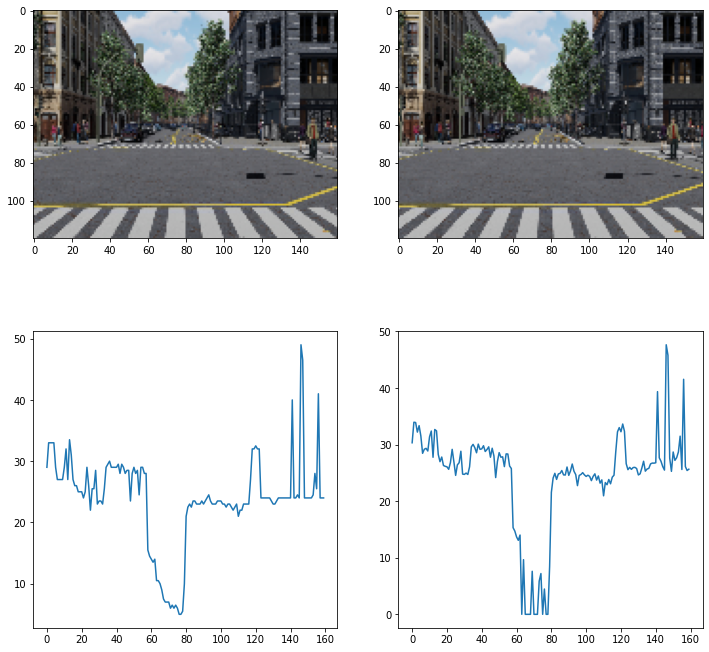

In [ ]:
# Seleciona exemplo para análise
index = 97
left_img = left_img_batch[index]
right_img = right_img_batch[index]
disp_img = disp_img_batch[index]
y_prev = y_prev_batch[index]

# Retira eixos dos exemplos
left_img = np.squeeze(left_img)
right_img = np.squeeze(right_img)
y_prev = np.squeeze(y_prev)

# Mostra resultados do exemplos slecionado
f, pos = plt.subplots(2, 2, figsize=(12, 12))
pos[0,0].imshow(left_img)
pos[0,1].imshow(right_img)
pos[1,0].plot(disp_img)
pos[1,1].plot(y_prev)
plt.show()

In [ ]:
# Calcula erro de previsão da imagem selecionada
erro = np.mean(100*np.abs(y_prev - disp_img))/np.mean(disp_img)
print('Erro absoluto médio percentual (%):', erro)

# Apresenta alguns valores das imagens segmentadas
print(y_prev[:20].astype(int))
print(disp_img[:20].astype(int))

Erro absoluto médio percentual (%): 7.4232154
[30 33 33 32 33 31 28 29 29 28 31 32 27 32 32 28 26 27 26 26]
[29 33 33 33 33 29 27 27 27 27 29 32 27 33 31 27 26 26 25 25]


## Exemplo 3

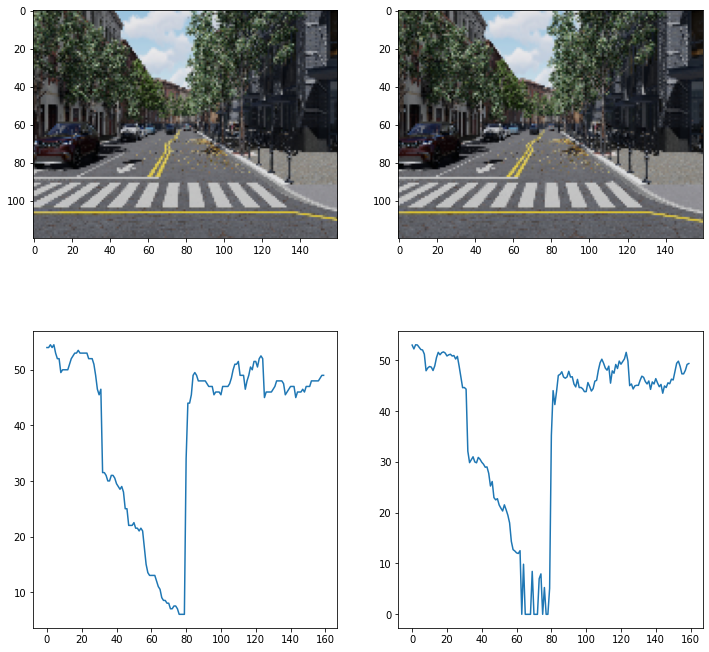

In [ ]:
# Seleciona exemplo para análise
index = 149
left_img = left_img_batch[index]
right_img = right_img_batch[index]
disp_img = disp_img_batch[index]
y_prev = y_prev_batch[index]

# Retira eixos dos exemplos
left_img = np.squeeze(left_img)
right_img = np.squeeze(right_img)
y_prev = np.squeeze(y_prev)

# Mostra resultados do exemplos slecionado
f, pos = plt.subplots(2, 2, figsize=(12, 12))
pos[0,0].imshow(left_img)
pos[0,1].imshow(right_img)
pos[1,0].plot(disp_img)
pos[1,1].plot(y_prev)
plt.show()

In [ ]:
# Calcula erro de previsão da imagem selecionada
erro = np.mean(100*np.abs(y_prev - disp_img))/np.mean(disp_img)
print('Erro absoluto médio percentual (%):', erro)

# Apresenta alguns valores das imagens segmentadas
print(y_prev[:20].astype(int))
print(disp_img[:20].astype(int))

Erro absoluto médio percentual (%): 4.2761474
[52 52 53 52 52 52 51 51 47 48 48 48 47 48 50 51 51 51 51 51]
[54 54 54 54 54 53 52 52 49 50 50 50 50 51 52 52 53 53 53 53]
